In [25]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from matplotlib import pyplot
from matplotlib.image import imread
import os
import cv2
import random
from tqdm import tqdm
from os import path
import pickle

FOLDER = '/train/'
IMG_SIZE = 100
CURRENT_DIR = path.abspath(path.curdir)
BATCH_SIZE = 128

#https://becominghuman.ai/image-classification-with-tensorflow-2-0-without-keras-e6534adddab2
#https://colab.research.google.com/drive/15QZMSIrvE4MgVq2GnQ0XUsqQssY6sn7w#scrollTo=VXSI7DnehJhE&forceEdit=true&sandboxMode=true

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [22]:
files = os.listdir(CURRENT_DIR + FOLDER)
categories = []
images = []

for file in tqdm(files):
    category = file.split('.')[0]
    
    if category=='dog':
        categories.append(1)
        
    else:
        categories.append(0)
        
    image = cv2.imread(os.path.join(CURRENT_DIR + FOLDER,file),cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    images.append(image)
    
train = pd.DataFrame({'image':images,'category':categories}).sample(frac=1).reset_index(drop=True)

100%|██████████| 25000/25000 [01:29<00:00, 280.82it/s]


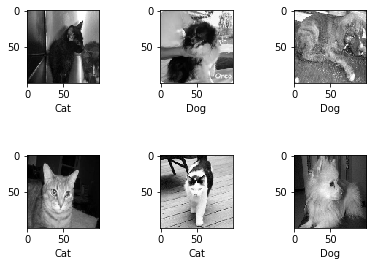

In [23]:
for i in range(6):
    pyplot.subplot(2,3,i+1)
    
    sample = train.sample(n=1)
    pyplot.imshow(sample['image'].values[0],cmap='gray')
    
    label = 'Cat' if sample['category'].values[0]==0 else 'Dog'
    pyplot.xlabel(label)

pyplot.subplots_adjust(right=1,hspace=1)

In [62]:
x = np.array(train['image'])
y = np.array(train['category'])


pickle_out = open('x.pickle','wb')
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open('y.pickle','wb')
pickle.dump(y,pickle_out)
pickle_out.close()

In [26]:
pickle_in = open('x.pickle','rb')
train_image = pickle.load(pickle_in)

pickle_in = open('y.pickle','rb')
train_category = pickle.load(pickle_in)

In [65]:
LEAKY_RELU_ALPHA = 0.2
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001
EPOCHS = 100

def conv2d(inputs, filters, stride_size):
    out = tf.nn.conv2d(inputs, filters, strides=[1,stride_size,stride_size,1], padding='SAME') 
    return tf.nn.leaky_relu(out, alpha=LEAKY_RELU_ALPHA) 

def maxpool(inputs, pool_size, stride_size):
    return tf.nn.max_pool2d(inputs, ksize=[1, pool_size, pool_size,1], padding='VALID', strides=[1, stride_size, stride_size, 1])

def dense(inputs, weights):
    x = tf.nn.leaky_relu(tf.matmul(inputs, weights), alpha=LEAKY_RELU_ALPHA)
    return tf.nn.dropout(x, rate=DROPOUT_RATE)

initializer = tf.initializers.glorot_uniform()
def get_weight(shape, name):
    return tf.Variable(initializer(shape), name=name, trainable=True, dtype=tf.float32)


In [64]:
shapes = [
    [3, 3, 3, 16], 
    [3, 3,16, 16], 
    [3, 3, 16,32], 
    [3, 3, 32, 32],
    [3, 3, 32, 64], 
    [3, 3, 64, 64],
    [3, 3, 64, 128], 
    [3, 3, 128, 128],
    [3, 3, 128, 256], 
    [3, 3, 256, 256],
    [3, 3, 256, 512], 
    [3, 3, 512, 512],
    [8192, 3600], 
    [3600, 2400],
    [2400, 1600], 
    [1600, 800],
    [800, 64],
    [64, 1],
]

weights = []
for i,shape in enumerate(shapes):
    weights.append(get_weight(shape,f'weight{i}'))


In [45]:
def model(x):
    x = tf.cast(x, dtype=tf.float32)
    c1 = conv2d(x, weights[0], stride_size=1) 
    c1 = conv2d(c1, weights[1], stride_size=1) 
    p1 = maxpool(c1, pool_size=2, stride_size=2)
    
    c2 = conv2d(p1, weights[2], stride_size=1)
    c2 = conv2d(c2, weights[3], stride_size=1) 
    p2 = maxpool(c2, pool_size=2, stride_size=2)
    
    c3 = conv2d(p2, weights[4], stride_size=1) 
    c3 = conv2d(c3, weights[5], stride_size=1) 
    p3 = maxpool(c3, pool_size=2, stride_size=2)
    
    c4 = conv2d(p3, weights[6], stride_size=1)
    c4 = conv2d(c4, weights[7], stride_size=1)
    p4 = maxpool(c4, pool_size=2, stride_size=2)

    c5 = conv2d(p4, weights[ 8 ], stride_size=1)
    c5 = conv2d(c5, weights[ 9 ], stride_size=1)
    p5 = maxpool(c5, pool_size=2, stride_size=2)

    c6 = conv2d(p5, weights[10], stride_size=1)
    c6 = conv2d(c6, weights[11], stride_size=1)
    p6 = maxpool(c6, pool_size=2, stride_size=2)

    flatten = tf.reshape(p6, shape=(tf.shape(p6)[0], -1))

    d1 = dense(flatten , weights[ 12 ] )
    d2 = dense(d1, weights[13])
    d3 = dense(d2, weights[14])
    d4 = dense(d3, weights[15])
    d5 = dense(d4, weights[16])
    logits = tf.matmul(d5, weights[17])

    return tf.nn.softmax(logits)

In [46]:
def loss(pred, target):
    return tf.losses.categorical_crossentropy(target, pred)

optimizer = tf.optimizers.Adam(LEARNING_RATE)

def train_step(model, inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(model(inputs), outputs)
    grads = tape.gradient(current_loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    print(tf.reduce_mean(current_loss))

In [73]:
for _ in range(EPOCHS):
#     for sample in zip(train_image,train_category):
#         train_step(model,sample[0],sample[1])
    train_step(model,train_image,train_category)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [68]:
print(len(train_image))
print(len(train_image[0]))

25000
100


In [81]:
train_image[1:3]

AttributeError: 'numpy.ndarray' object has no attribute 'value'

(25000,)

(7, 6)